# Feature tracing

## Config and preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Overwrite once you get good examples
SAMPLE_IDX = 0
TOKEN_IDX = 0

FEATURE_ID, SAMPLE_IDX, TOKEN_IDX = 15954, 89597, 18  # www
# FEATURE_ID = 4542 # it is
# FEATURE_ID, SAMPLE_IDX, TOKEN_IDX = 8, 38, 73 # ')
# FEATURE_ID = 10996 # 't
BATCH_SIZE = 32
HEAD = 3

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from transformer_lens import utils

from sprint.loading import load_all
from sprint.linearization import analyze_linearized_feature
from sprint.attention import get_attn_head_contribs, get_attn_head_contribs_ov
from sprint.sae_tutorial import make_token_df, process_tokens
from sprint.visualization import plot_head_token_contribs, plot_head_token_contribs_for_prompt, visualize_topk

/opt/conda/envs/sprint/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model, data, sae = load_all(half_precision=True, verbose=False)  # , fold_ln=True)
# batch = data[:BATCH_SIZE]  # convenience variable for callign make_token_df
(
    BATCH_IDX,
    IDX_IN_BATCH,
) = (
    SAMPLE_IDX // BATCH_SIZE,
    SAMPLE_IDX % BATCH_SIZE,
)
batch = data[BATCH_IDX * BATCH_SIZE : (BATCH_IDX + 1) * BATCH_SIZE]

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 2048,
 'dict_mult': 8,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'lr': 0.0001,
 'model_batch_size': 512,
 'num_tokens': 2000000000,
 'seed': 52,
 'seq_len': 128}


In [5]:
result = analyze_linearized_feature(
    feature_idx=FEATURE_ID,
    sample_idx=SAMPLE_IDX,
    token_idx=TOKEN_IDX,
    model=model,
    data=data,
    encoder=sae,
    head=HEAD,
    batch_size=BATCH_SIZE,
)

# TODO: get rid of the TOKEN_IDX argument and automate it instead

## Feature interpretation
We look at:
* A table of specific tokens by feature activations
* A table of specific tokens by activation scores
* A table of generic tokens by unembedded token scores


In [6]:
# Table of top SAE activations

token_df = make_token_df(batch, model=model)
token_df["feature"] = utils.to_numpy(result["sae activations"][:, FEATURE_ID])
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

,str_tokens,unique_token,context,batch,pos,label,feature
3730,·www,·www/18,"·locations,·please·visit:|·www|.",29,18,29/18,4.015625
3737,·www,·www/25,parkmobile.io·or|·www|.,29,25,29/25,2.683594
0,<|BOS|>,<|BOS|>/0,|<|BOS|>|·conflict,0,0,0/0,0.000000
2733,f,f/45,_http_info(|f|acet,21,45,21/45,0.000000
2721,_,_/33,_monitored_application|_|for,21,33,21/33,0.000000
2722,for,for/34,monitored_application_|for|_,21,34,21/34,0.000000
2723,_,_/35,itored_application_for|_|f,21,35,21/35,0.000000
2724,f,f/36,_application_for_|f|acet,21,36,21/36,0.000000
2725,acet,acet/37,application_for_f|acet|_,21,37,21/37,0.000000
2726,_,_/38,_for_facet|_|with,21,38,21/38,0.000000


In [7]:
# Table of activation scores

token_df = make_token_df(batch, model=model)
token_df["feature"] = utils.to_numpy(result["activation scores"])
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

,str_tokens,unique_token,context,batch,pos,label,feature
971,_,_/75,['name']↩ ↩ ········query|_|params,7,75,7/75,1.239258
985,_,_/89,·in·params:↩ ············query|_|params,7,89,7/89,1.159180
3701,\(,\(/117,·=·regex.sub('|\(|.*,28,117,28/117,1.079102
1005,_,_/109,·in·params:↩ ············query|_|params,7,109,7/109,0.955566
3737,·www,·www/25,parkmobile.io·or|·www|.,29,25,29/25,0.890137
3301,·‘,·‘/101,·student·executive·committee.·See|·‘|Orientation,25,101,25/101,0.420166
1493,_,_/85,·str(self.help|_|footer,11,85,11/85,0.338379
1438,_,_/30,name·=·self.help|_|lookup,11,30,11/30,0.274170
1485,_,_/77,·help_text·=·help|_|text,11,77,11/77,0.226196
1276,·pyl,·pyl/124,iteration()··#|·pyl|int,9,124,9/124,0.026108


In [8]:
# Unembed feature

token_df = pd.DataFrame(
    dict(str_tokens=result["token strings"], feature_scores=result["token scores"].detach().cpu().numpy())
)
token_df.style.background_gradient("coolwarm")

,str_tokens,feature_scores
0,テ,8.187500
1,$^{-,8.187500
2,geb,8.101562
3,--------,7.109375
4,autoc,7.027344
5,最,6.968750
6,}^,6.968750
7,misunder,6.945312
8,相,6.925781
9,probl,6.902344


Tokens shape: torch.Size([215402, 128]), dtype: torch.int64, device: cuda:0


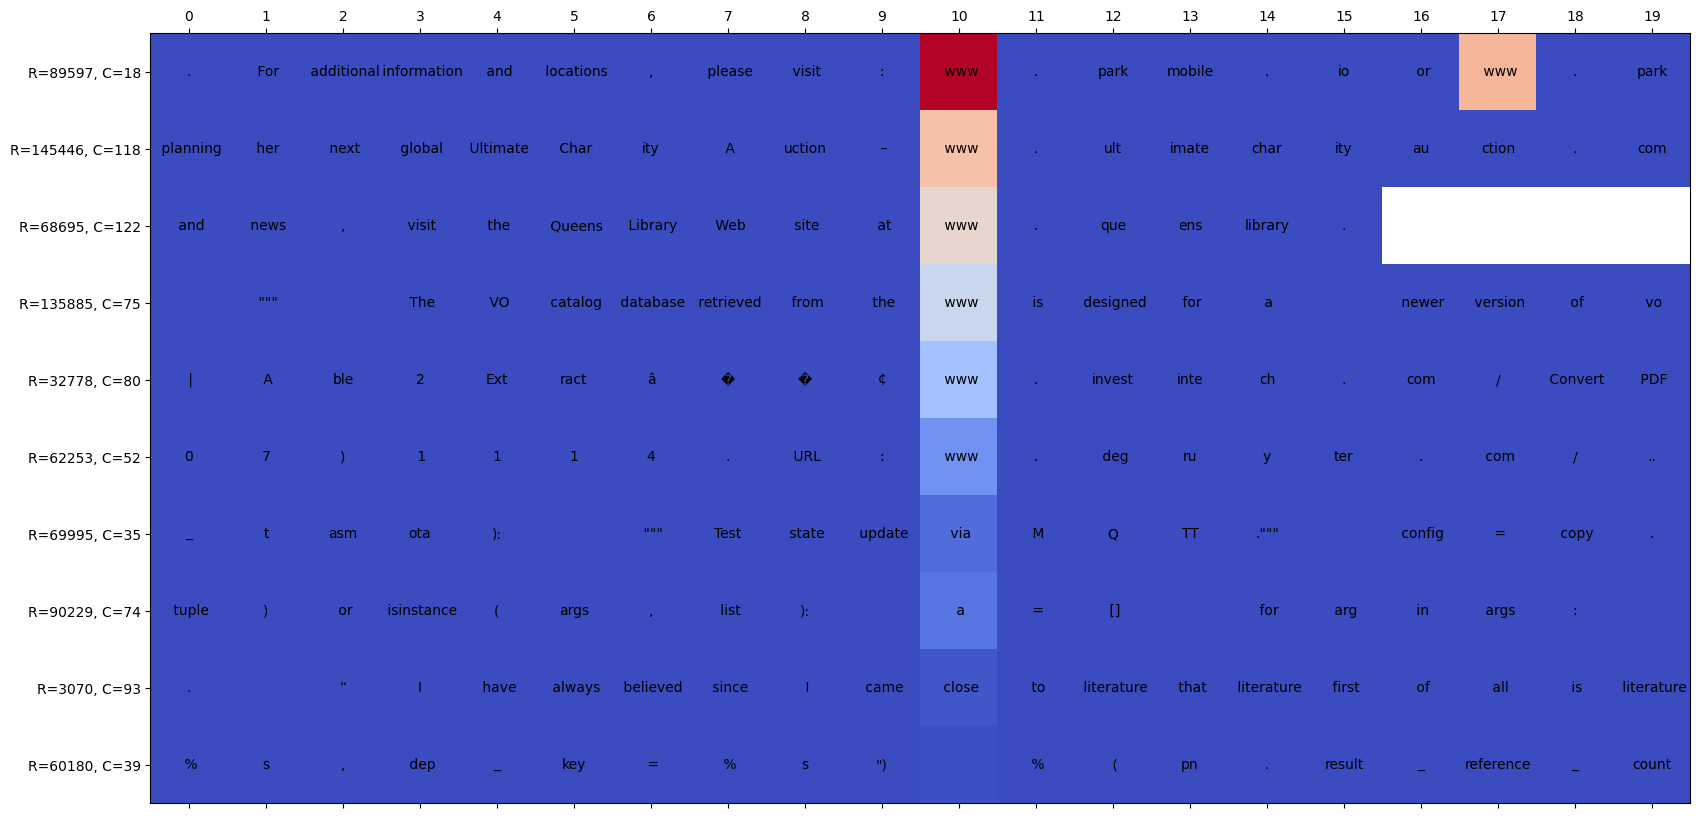

In [17]:
# A more contextualized view of the feature
# This looks at the ACTUAL top K activations in the dataset, not just in a batch

visualize_topk(feature_id=FEATURE_ID, n_examples=10, model=model, data=data, pad=True, clip=10, evenly_spaced=True)
plt.show()

I skipped the exploration of linearization points, because you can do this by just changing the `sample_idx` and `token_idx` parameters in `anlyze_linearized_feature()`

## Attention

### Head contributions

In [10]:
attn_contribs = get_attn_head_contribs(
    model=model, data=data, layer=0, range_normal=result["mid"], batch_size=BATCH_SIZE
)

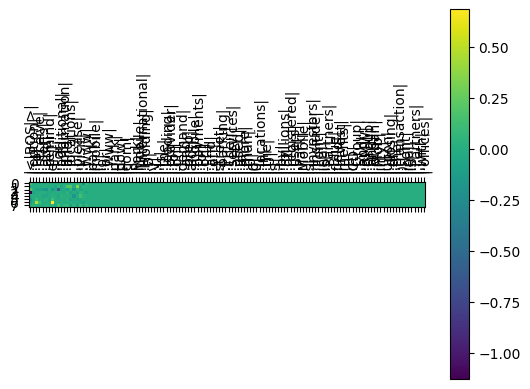

In [11]:
plot_head_token_contribs(model=model, contribs=attn_contribs, tokens=data[SAMPLE_IDX], dst=TOKEN_IDX)
plt.show()

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0


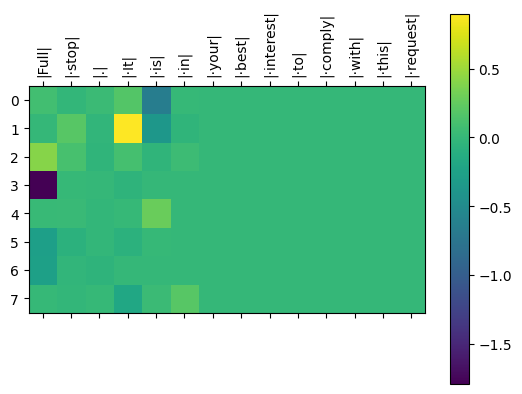

In [12]:
# prompt = "\n           'sms_id_string':   ('"
prompt = "Full stop. It is in your best interest to comply with this request"
plot_head_token_contribs_for_prompt(
    model=model,
    prompt=prompt,
    range_normal=result["mid"],
    # dst=-1,
    dst=5,
    prepend_bos=True,
)
plt.show()

# TODO: figure out whether there's an off-by-one error in the attention visualization
# TODO: fix the activating examples visualization

### OV circuit

In [13]:
# Scores when OV circuit is accounted for before unembedding

token_df = pd.DataFrame(
    dict(
        str_tokens=process_tokens(result["OV token strings"], model=model),
        feature_scores=result["OV token scores"].detach().cpu().numpy(),
    )
)
token_df.style.background_gradient("coolwarm")

,str_tokens,feature_scores
0,·Sug,3.916016
1,·Pir,3.660156
2,·Gir,3.515625
3,Ald,3.421875
4,·MAG,3.419922
5,·Spl,3.406250
6,·Mant,3.400391
7,·Lar,3.292969
8,·McK,3.283203
9,·Viv,3.255859


In [14]:
# Same as above, but ln + OV

token_df = pd.DataFrame(
    dict(
        str_tokens=process_tokens(result["ln+OV token strings"], model=model),
        feature_scores=result["ln+OV token scores"].detach().cpu().numpy(),
    )
)
token_df.style.background_gradient("coolwarm")

# TODO: look into what's broken about this
# TODO: what's going on with the positional embeddings?

,str_tokens,feature_scores
0,ir,1.083984
1,�,0.992676
2,og,0.980957
3,ell,0.911621
4,�,0.899902
5,�,0.881836
6,·are,0.838379
7,�,0.833984
8,,0.824707
9,�,0.800781


### QK circuit

In [15]:
token_df = pd.DataFrame(
    dict(
        str_tokens=process_tokens(result["QK token strings"], model=model),
        feature_scores=result["QK token scores"].detach().cpu().numpy(),
    )
)
token_df.style.background_gradient("coolwarm")

,str_tokens,feature_scores
0,д,9.156250
1,↩ ↩ ·,8.484375
2,↩ ··↩ ·,8.375000
3,�,8.320312
4,ocl,8.304688
5,�,8.242188
6,ж,8.218750
7,↩ ↩ ↩ ···,7.949219
8,·comun,7.902344
9,Ar,7.804688
